In [1]:
from datasets import SyntheticDataset
from crowd_evaluation import OldEvaluator, ConfidenceEvaluatorC
import numpy as np

In [2]:
from joblib import Memory, Parallel, delayed
memory = Memory('calc_time_vs_accuracy', verbose=0)

@memory.cache
def calc_fraction_of_wrong_interval_estimates(
        num_samples: int,
        num_workers: int,
        confidence: float,
        evaluator_name: str,
        iter_count: int):

    int_sizes = np.zeros(iter_count * num_workers, dtype=np.float32)
    correct_interval_estimates = 0
    for i in range(iter_count):
        p_true = np.random.choice([0.1, 0.08, 0.06], p=[0.3, 0.4, 0.3], size=num_workers)
        dataset = SyntheticDataset(num_samples=num_samples, num_workers=num_workers, p_true=p_true)

        if evaluator_name == 'old':
            evaluator = OldEvaluator(dataset)
            ps, confs = evaluator.evaluate_workers_with_confidence(
                dataset.workers,
                confidence=confidence,
                method='exhaustive'
            )
        elif evaluator_name == 'old greedy':
            evaluator = OldEvaluator(dataset)
            ps, confs = evaluator.evaluate_workers_with_confidence(
                dataset.workers,
                confidence=confidence,
                method='greedy'
            )
        else:
            evaluator = ConfidenceEvaluatorC(dataset)
            ps, confs = evaluator.evaluate_workers_with_confidence(
                dataset.workers,
                confidence=confidence,
            )

        min_limit, max_limit = ps-confs, ps+confs
        inside_interval = np.where((min_limit <= p_true) & (p_true <= max_limit), 1, 0)
        correct_interval_estimates += np.count_nonzero(inside_interval)
        int_sizes[i*num_workers:(i+1)*num_workers] = 2*confs

    total_acc = correct_interval_estimates / (num_workers * iter_count)
    return total_acc, np.mean(int_sizes), np.std(int_sizes)

In [10]:
from visualizations.utils import say
from tqdm import tqdm

# num_workers/num_samples configurations to analyze
num_tasks = np.array([10, 25, 50, 75, 100, 150, 200, 300, 500])
num_workers = [7]
iteration_count = 100
evaluater_names = ['new', 'old greedy']
confidence_level = 0.9
# evaluater_names = ['old', 'old greedy', 'new']

accuracies = dict()
interval_sizes = dict()

for m in num_workers:
    accuracies[m] = dict()
    interval_sizes[m] = dict()

    for t in evaluater_names:
        print('num_workers: ' + str(num_workers) + ', evaluator: ' + t)
        res = Parallel(n_jobs=7)(delayed(calc_fraction_of_wrong_interval_estimates)
                (num_tasks, m, confidence_level, t, iteration_count) for num_tasks in tqdm(num_tasks))

        accs_result = [x[0] for x in res]
        interval_sizes_result = [x[1] for x in res]

        accuracies[m][t] = accs_result
        interval_sizes[m][t] = interval_sizes_result
        # print('Accuracies:', dict(zip(confidence_levels, accs_result)), '\n')
        # print('Interval sizes:', dict(zip(confidence_levels, interval_sizes_result)), '\n\n')

say("Accuracy and interval size vs confidence calculations completed")

num_workers: [7], evaluator: new


100%|██████████| 9/9 [00:00<00:00, 134.13it/s]


num_workers: [7], evaluator: old greedy


100%|██████████| 9/9 [00:00<00:00, 8770.62it/s]


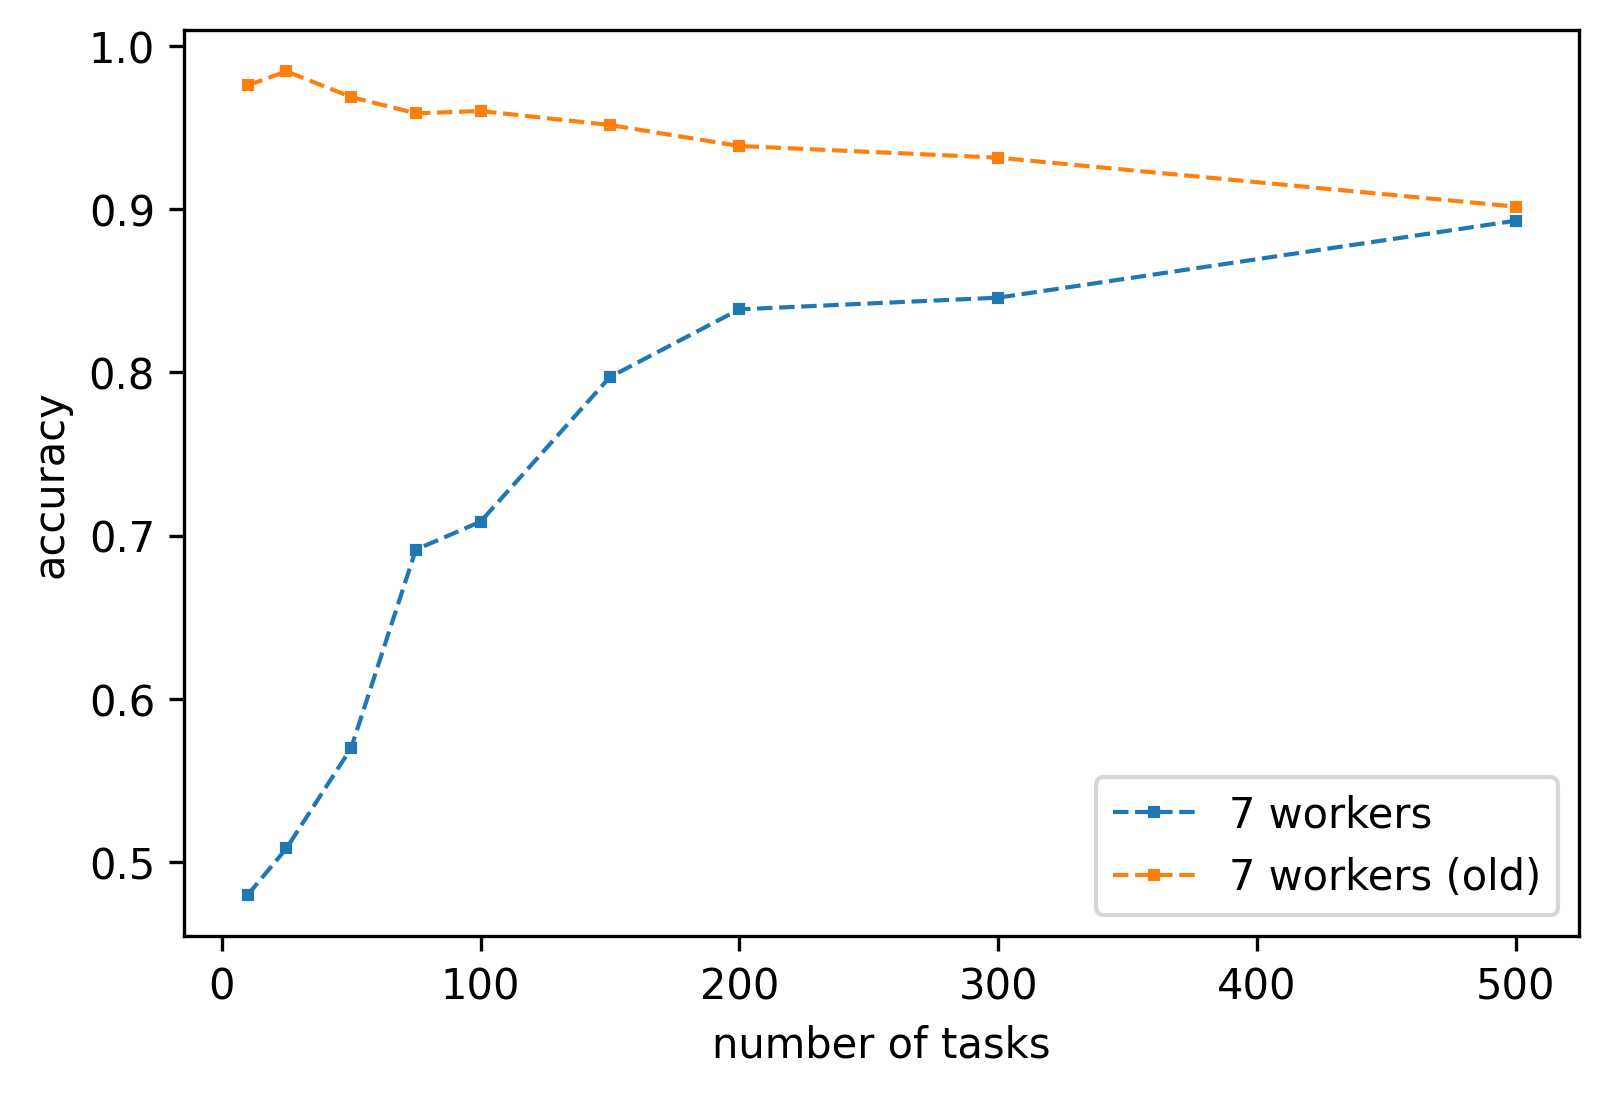

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

mpl.rcParams['figure.dpi'] = 300

plt.plot(num_tasks,
         accuracies[7]['new'],
         label = '7 workers',
         marker='s', linestyle='--', linewidth=1, markersize=2)

plt.plot(num_tasks,
         accuracies[7]['old greedy'],
         label = '7 workers (old)',
         marker='s', linestyle='--', linewidth=1, markersize=2)
plt.xlabel('number of tasks')
plt.ylabel('accuracy')
plt.legend()
plt.show()

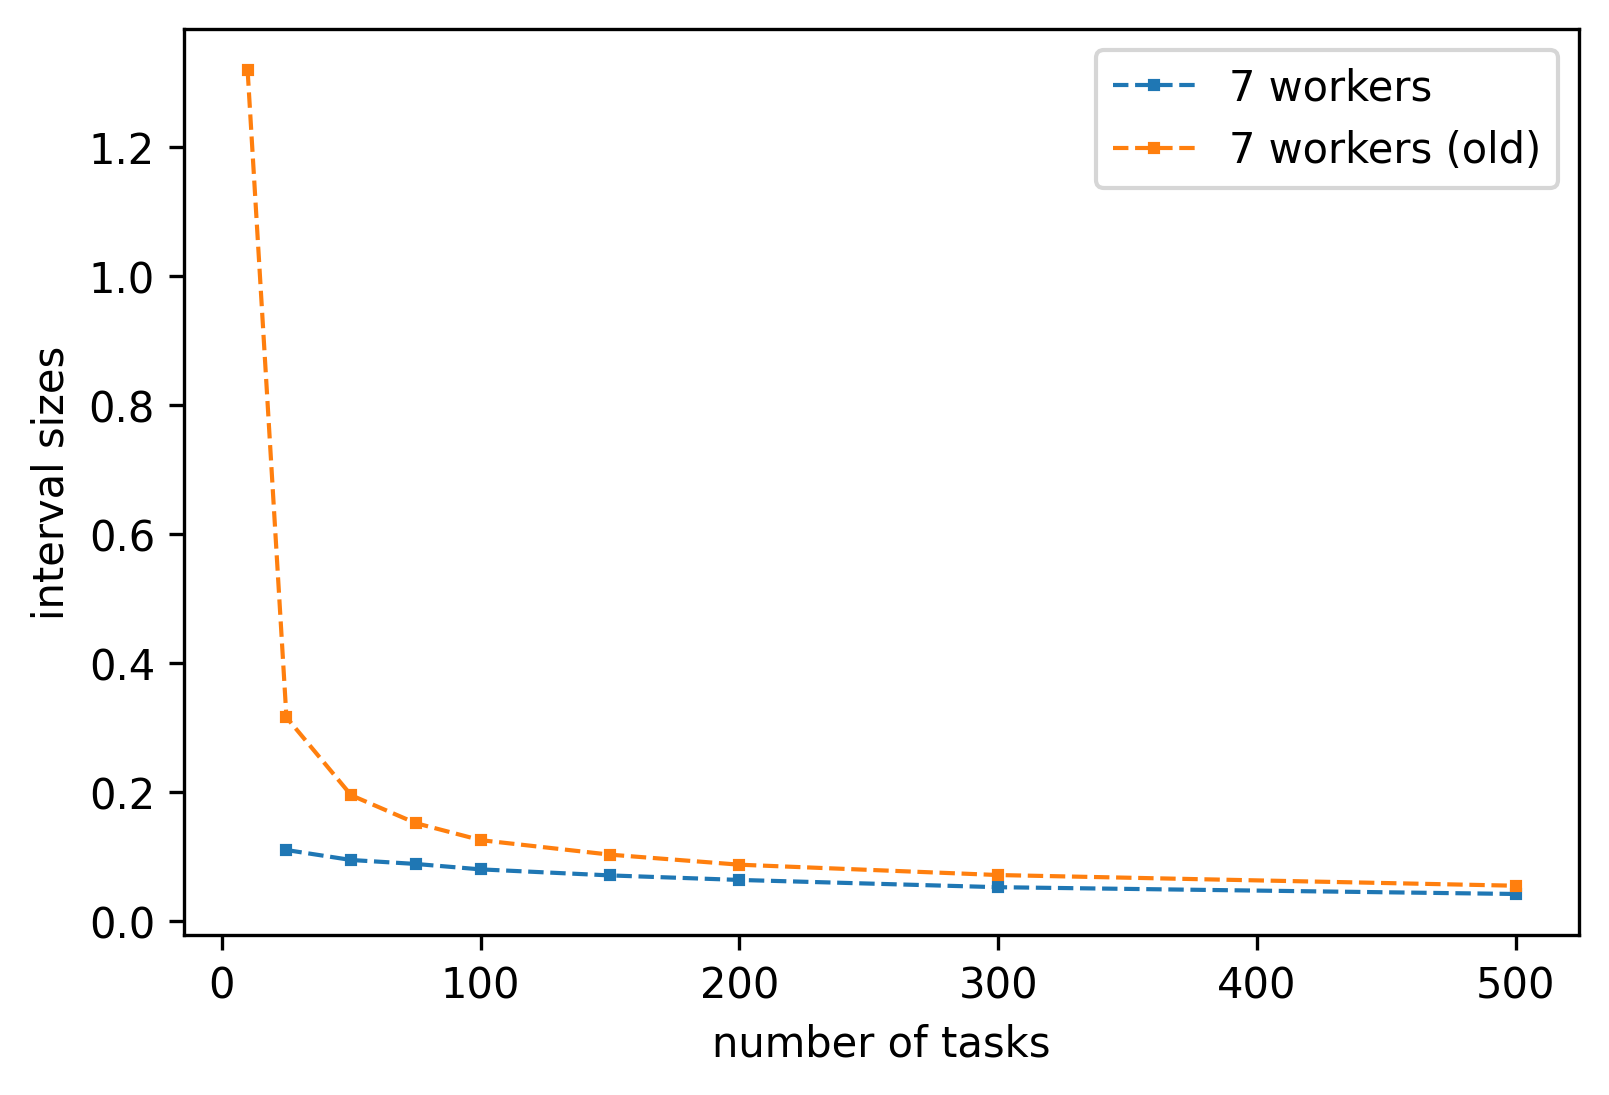

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

mpl.rcParams['figure.dpi'] = 300

plt.plot(num_tasks,
         interval_sizes[7]['new'],
         label = '7 workers',
         marker='s', linestyle='--', linewidth=1, markersize=2)

plt.plot(num_tasks,
         interval_sizes[7]['old greedy'],
         label = '7 workers (old)',
         marker='s', linestyle='--', linewidth=1, markersize=2)
plt.xlabel('number of tasks')
plt.ylabel('interval sizes')
plt.legend()
plt.show()